### Imports

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import itertools
import matplotlib.pyplot as plt
from terminaltables import AsciiTable

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

### Load datasets

In [2]:
# Load feature set and target values
dataset = pd.read_pickle("data/dataset")
articles = pd.read_pickle("data/articles")

auto_extracted_X = np.load("data/auto_extracted_features.npy")

### Prepare data

In [3]:
# Turn into numpy arrays
X = normalize(dataset.iloc[:, :-1].values)
y = dataset.iloc[:, -1].values.flatten()

n = len(X)

# Test indices: 20% of total, randomly selected
test_idx = np.random.choice(range(n), size=int(0.2*n), replace=False)
# Train indices: The rest
train_idx = np.array([i for i in range(n) if i not in test_idx])


# Split the training and test sets
X_train, X_test = X[train_idx], X[test_idx]

auto_X_train, auto_X_test = auto_extracted_X[train_idx], auto_extracted_X[test_idx]

y_train, y_test = y[train_idx], y[test_idx]

### Classify

In [4]:
# Define classifier
clf = RandomForestClassifier(n_estimators=100)

# Fit - Train
clf.fit(X_train, y_train)

# Make a prediction on test set
y_pred = clf.predict(X_test)

# Measure the performance of the model
print ("Test set accuracy: %.2f%%\n" %  float(100*accuracy_score(y_test, y_pred)))

print (classification_report(y_test, y_pred, target_names=["News", "Blog"]))


Test set accuracy: 69.83%

             precision    recall  f1-score   support

       News       0.68      0.72      0.70       590
       Blog       0.71      0.68      0.70       610

avg / total       0.70      0.70      0.70      1200



### Classify (with auto extracted features)

In [5]:
# Define classifier
clf = RandomForestClassifier(n_estimators=100)

# Fit - Train
clf.fit(auto_X_train, y_train)

# Make a prediction on test set
y_pred = clf.predict(auto_X_test)

# Measure the performance of the model
print ("Test set accuracy: %.2f%%\n" %  float(100*accuracy_score(y_test, y_pred)))

print (classification_report(y_test, y_pred, target_names=["News", "Blog"]))


Test set accuracy: 74.50%

             precision    recall  f1-score   support

       News       0.75      0.73      0.74       590
       Blog       0.74      0.76      0.75       610

avg / total       0.75      0.74      0.74      1200



### Save predictions

In [6]:
test_articles = articles.loc[test_idx]

# Save predictions
test_articles.loc[y_pred == 0, "prediction"] = "News"
test_articles.loc[y_pred == 1, "prediction"] = "Blog"

test_articles.to_csv("data/predictions.csv")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


### Plot confusion matrix

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


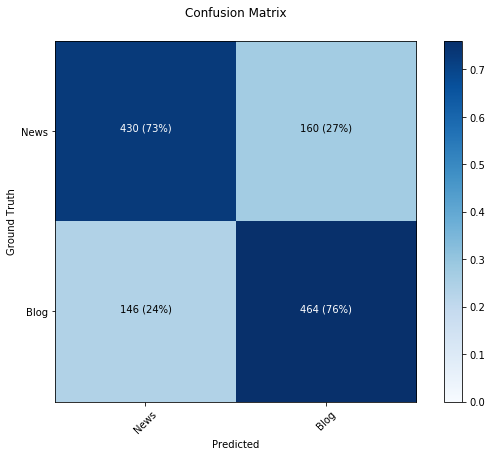

In [7]:

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
ax = fig.add_subplot(111)
cax = ax.matshow(cm_norm, interpolation='none', cmap=plt.cm.Blues, vmin=0, vmax=np.max(cm_norm))
ax.xaxis.tick_bottom()
fig.colorbar(cax)

thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "%d (%.f%%)" % (cm[i,j], float(100*cm_norm[i,j])),
             horizontalalignment="center",
             color="white" if cm_norm[i, j] > thresh else "black")

plt.tight_layout()
    
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.xticks(np.arange(2), ('News', 'Blog'), rotation=45)
plt.yticks(np.arange(2), ('News', 'Blog'))

plt.show()
plt.close()